In [21]:
import logging
from typing import List, Optional

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

from sahi.models.base import DetectionModel
from sahi.prediction import ObjectPrediction
from sahi.utils.cv import get_bbox_from_bool_mask, get_coco_segmentation_from_bool_mask
from sahi.utils.import_utils import check_requirements

In [ ]:
logger = logging.getLogger(__name__)

In [3]:
import cv2

In [ ]:
from detectron2.data import MetadataCatalog
from detectron2.engine.defaults import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config

from detectron2.config import LazyConfig, instantiate
from detectron2.checkpoint import DetectionCheckpointer
import detectron2.data.transforms as T

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
cfg = get_cfg()
cfg.set_new_allowed(True) 
cfg = LazyConfig.load("/home/mrajaraman/master-thesis-dragonfly/external/mask-rcnn-dragonfly/configs/new_baselines/mask_rcnn_R_50_FPN_100ep_LSJ.py") 
# cfg.train.init_checkpoint = "/h/jquinto/Mask-RCNN/model_final_14d201.pkl"

# set model device
# cfg.MODEL.DEVICE = "self.device.type"
cfg.train.device = "cuda"

# # set input image size
# # NEW TRAINING PIPELINE
# cfg.INPUT.MIN_SIZE_TEST = 1024
# cfg.INPUT.MAX_SIZE_TEST = 1024
# cfg.freeze()

In [39]:
model = instantiate(cfg.model)
DetectionCheckpointer(model).load("/home/mrajaraman/master-thesis-dragonfly/external/mask2former-dragonfly/output_lifeplan_b_512_sahi_tiled_v9_R50_1024_one_cycle_lr_5e-5_colour_augs_15k_iters/model_final.pth")
category_mapping={"0": "head", "1": "torso", "2": "tail", "3": "wings"}

09/19/2025 20:51:10 - INFO - detectron2.checkpoint.detection_checkpoint -   [DetectionCheckpointer] Loading from /home/mrajaraman/master-thesis-dragonfly/external/mask2former-dragonfly/output_lifeplan_b_512_sahi_tiled_v9_R50_1024_one_cycle_lr_5e-5_colour_augs_15k_iters/model_final.pth ...
09/19/2025 20:51:10 - INFO - fvcore.common.checkpoint -   [Checkpointer] Loading from /home/mrajaraman/master-thesis-dragonfly/external/mask2former-dragonfly/output_lifeplan_b_512_sahi_tiled_v9_R50_1024_one_cycle_lr_5e-5_colour_augs_15k_iters/model_final.pth ...
09/19/2025 20:51:10 - WARNING - fvcore.common.checkpoint -   Some model parameters or buffers are not found in the checkpoint:
backbone.bottom_up.res2.0.conv1.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res2.0.conv1.weight
backbone.bottom_up.res2.0.conv2.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res2.0.conv2.weight
backbone.bottom_up.res2.0.conv3.norm.{bias, running_mean, running_var, weight}
backb

In [23]:
import random

In [47]:
def get_prediction(img_path, threshold):
    # Load image
    pil_img = Image.open(img_path).convert("RGB")
    image_np = np.array(pil_img)  # (H, W, C), RGB

    # Apply test-time augmentations
    mapper = instantiate(cfg.dataloader.test.mapper)
    aug = mapper.augmentations
    aug_input = T.AugInput(image_np)
    _ = aug(aug_input)
    image_np = aug_input.image

    # Convert to tensor
    image = torch.as_tensor(image_np.astype("float32").transpose(2, 0, 1))
    inputs = {"image": image.to(device)}

    # Forward pass
    model.eval()
    with torch.no_grad():
        pred = model([inputs])

    # Get instances
    instances = pred[0]["pred_instances"].to("cpu")

    # Filter by threshold
    keep = instances.scores > threshold
    instances = instances[keep]

    # Extract outputs
    scores = instances.scores.numpy()
    boxes = instances.pred_boxes.tensor.numpy()
    masks = instances.pred_masks.numpy()
    labels = instances.pred_classes.numpy()

    # Map labels to class names
    pred_class = [category_mapping[str(i)] for i in labels]
    pred_boxes = [[(x1, y1), (x2, y2)] for (x1, y1, x2, y2) in boxes]

    return masks, pred_boxes, pred_class


In [48]:
# def random_colour_masks(image): # Takes a binary mask as input
#       colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80,
#                      190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
#       # Extracting all the channels
#       r = np.zeros_like(image).astype(np.uint8)
#       g = np.zeros_like(image).astype(np.uint8)
#       b = np.zeros_like(image).astype(np.uint8)
#       # Assigning random colors to each instances of segmentation defferenciated by white  
#       r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
#       coloured_mask = np.stack([r, g, b], axis=2)

#       return coloured_mask

# Visualization function
def instance_segmentation_api(img_path, threshold=0.5, text_th=1):
      masks, boxes, pred_cls = get_prediction(img_path, threshold)
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      for i in range(len(masks)):
           #rgb_mask = random_colour_masks(masks[i])
      #      img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
           xmin,ymin,xmax,ymax=int(boxes[i][0][0]), int(boxes[i][0][1]),int(boxes[i][1][0]), int(boxes[i][1][1])
           cv2.rectangle(img, (xmin,ymin), (xmax+5,ymax-2), (0,255,0), 1)
           cv2.putText(img, pred_cls[i], (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), text_th)

      plt.figure(figsize=(20,30))
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      plt.show()

instance_segmentation_api("/home/mrajaraman/dataset/originals/img_1458477504.jpg")# Replace with your image path

09/19/2025 20:56:14 - INFO - detectron2.data.dataset_mapper -   [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=1024)]


KeyError: 'pred_instances'

In [16]:
# category_names = list(category_mapping.values())
image = np.array(
    cv2.imread(
        '/home/mrajaraman/dataset/originals/img_1458477504.jpg', 
        cv2.IMREAD_COLOR
))

In [17]:
if isinstance(image, np.ndarray) and cfg.dataloader.train.mapper.image_format == "BGR":
        # convert RGB image to BGR format
        image = image[:, :, ::-1]
height, width = image.shape[:2]
mapper = instantiate(cfg.dataloader.test.mapper)
aug = mapper.augmentations
image = aug(T.AugInput(image)).apply_image(image)
image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
image = image.to(device)

model.to(device)
model.eval()

09/19/2025 19:07:26 - INFO - detectron2.data.dataset_mapper -   [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=1024)]


GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(
      256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fpn_output2): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fpn_lateral3): Conv2d(
      512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fpn_output3): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fpn_lateral4): Conv2d(
      1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

In [18]:
with torch.no_grad():
        inputs = {"image": image, "height": height, "width": width}
prediction_result = model([inputs])[0]


In [19]:
print(prediction_result)

{'instances': Instances(num_instances=0, image_height=353, image_width=500, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4), grad_fn=<ReshapeAliasBackward0>)), scores: tensor([], device='cuda:0', grad_fn=<IndexBackward0>), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 353, 500), dtype=torch.bool)])}


In [20]:
img = prediction_result['instances'][0]._fields['pred_masks'].cpu().detach().numpy()
bbox = []
print("Number of detected instances is ", len(prediction_result['instances']._fields['pred_boxes'].tensor))
for i in prediction_result['instances']._fields['pred_boxes'].tensor:
        print("i is ", i)
        bbox.append(i.cpu().detach().numpy())

# Display the image
plt.imshow(Image.open('/home/mrajaraman/dataset/originals/img_1458477504.jpg'))

IndexError: Instances index out of range!

In [ ]:
for i in range(len(bbox)):
        # print("length is ", len(bbox))
        plt.gca().add_patch(Rectangle((bbox[i][0], bbox[i][1]), bbox[i][2]-bbox[i][0], bbox[i][3]-bbox[i][1], linewidth=1, edgecolor='r', facecolor='none'))
        print(f"Instance {i+1} added to image")

plt.title("Inference Result of MaskRCNN on image")
plt.savefig("trained_inference_maskrcnn.png")

In [ ]:
print(aug)
print()

# Output sample mask predictions:
sample_preds = prediction_result['instances'][0]._fields['pred_masks'].cpu().detach().numpy()
print(sample_preds)
print(sample_preds.shape)
print(sample_preds.dtype)

09/19/2025 22:43:22 - INFO - detectron2.checkpoint.detection_checkpoint -   [DetectionCheckpointer] Loading from /home/mrajaraman/master-thesis-dragonfly/external/mask2former-dragonfly/output_lifeplan_b_512_sahi_tiled_v9_R50_1024_one_cycle_lr_5e-5_colour_augs_15k_iters/model_final.pth ...
09/19/2025 22:43:22 - INFO - fvcore.common.checkpoint -   [Checkpointer] Loading from /home/mrajaraman/master-thesis-dragonfly/external/mask2former-dragonfly/output_lifeplan_b_512_sahi_tiled_v9_R50_1024_one_cycle_lr_5e-5_colour_augs_15k_iters/model_final.pth ...
09/19/2025 22:43:22 - WARNING - fvcore.common.checkpoint -   Some model parameters or buffers are not found in the checkpoint:
backbone.bottom_up.res2.0.conv1.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res2.0.conv1.weight
backbone.bottom_up.res2.0.conv2.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res2.0.conv2.weight
backbone.bottom_up.res2.0.conv3.norm.{bias, running_mean, running_var, weight}
backb

{'instances': Instances(num_instances=6, image_height=353, image_width=500, fields=[pred_boxes: Boxes(tensor([[  0.0000,   0.0000, 500.0000, 353.0000],
        [177.4247,   0.0000, 177.5701, 353.0000],
        [359.6880,   0.0000, 363.4079, 353.0000],
        [369.2262,   0.0000, 500.0000, 353.0000],
        [248.7891,   0.0000, 252.8632, 353.0000],
        [424.3461, 294.9991, 424.3470, 353.0000]], device='cuda:0',
       grad_fn=<IndexBackward0>)), scores: tensor([1., 1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<IndexBackward0>), pred_classes: tensor([1, 1, 1, 1, 1, 3], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, Fa

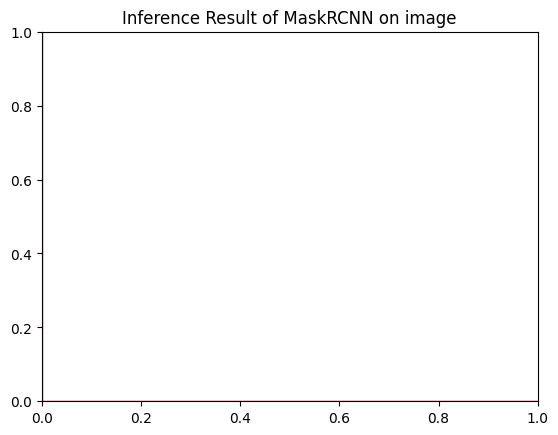

AugmentationList[ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=1024)]

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
(1, 353, 500)
bool


"\n>>> print(prediction_result['instances'][0]._fields['pred_masks'])\ntensor([[[0., 0., 0.,  ..., 0., 0., 0.],\n         [0., 0., 0.,  ..., 0., 0., 0.],\n         [0., 0., 0.,  ..., 0., 0., 0.],\n         ...,\n         [0., 0., 0.,  ..., 0., 0., 0.],\n         [0., 0., 0.,  ..., 0., 0., 0.],\n         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')\n>>> print(prediction_result['instances'][0]._fields['pred_masks'].size())\ntorch.Size([1, 256, 256])\n\n- Note: we can see here that the output mask predictions are a float32 array that \n        is the same size as the sample image that we are predicting on.\n>>> np.unique(sample_preds)\narray([0., 1.], dtype=float32)\n- Appears to be in RLE format -> indicating we have an RLE mask that by definition is pixel-based,\nso we can't have sub-pixel mask coordinates:\n\nThe process is:\n\nUpsample by 5x and round to nearest integer using +.5 trick\nGet dense boundary points at this higher resolution\nDownsample back by dividing by scale\nAp

In [51]:
import logging
from typing import List, Optional

import numpy as np
import torch

from sahi.models.base import DetectionModel
from sahi.prediction import ObjectPrediction
from sahi.utils.cv import get_bbox_from_bool_mask, get_coco_segmentation_from_bool_mask
from sahi.utils.import_utils import check_requirements

logger = logging.getLogger(__name__)

from detectron2.data import MetadataCatalog
from detectron2.engine.defaults import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.projects.deeplab import add_deeplab_config
import cv2
from detectron2.config import LazyConfig, instantiate
from detectron2.checkpoint import DetectionCheckpointer
import detectron2.data.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = get_cfg()
cfg.set_new_allowed(True) 
cfg = LazyConfig.load("/home/mrajaraman/master-thesis-dragonfly/external/mask-rcnn-dragonfly/configs/new_baselines/mask_rcnn_R_50_FPN_100ep_LSJ.py") 
# cfg.train.init_checkpoint = "/h/jquinto/Mask-RCNN/model_final_14d201.pkl"

# set model device
# cfg.MODEL.DEVICE = "self.device.type"
cfg.train.device = "cuda"

# # set input image size
# # NEW TRAINING PIPELINE
# cfg.INPUT.MIN_SIZE_TEST = 1024
# cfg.INPUT.MAX_SIZE_TEST = 1024
# cfg.freeze()

# init predictor
model = instantiate(cfg.model)
DetectionCheckpointer(model).load("/home/mrajaraman/master-thesis-dragonfly/external/mask2former-dragonfly/output_lifeplan_b_512_sahi_tiled_v9_R50_1024_one_cycle_lr_5e-5_colour_augs_15k_iters/model_final.pth")
# category_mapping={"1": "b"}

# detectron2 category mapping
category_names = list(category_mapping.values())
image = np.array(
    cv2.imread(
        "/home/mrajaraman/dataset/originals/img_1458477504.jpg", 
        cv2.IMREAD_COLOR
))

if isinstance(image, np.ndarray) and cfg.dataloader.train.mapper.image_format == "BGR":
        # convert RGB image to BGR format
        image = image[:, :, ::-1]
height, width = image.shape[:2]
mapper = instantiate(cfg.dataloader.test.mapper)
aug = mapper.augmentations
image = aug(T.AugInput(image)).apply_image(image)
image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
image = image.to(device)

model.to(device)
model.eval()

with torch.no_grad():
        inputs = {"image": image, "height": height, "width": width}
prediction_result = model([inputs])[0]
print(prediction_result)

img = prediction_result['instances'][0]._fields['pred_masks'].cpu().detach().numpy()
bbox = []
print("Number of detected instances is ", len(prediction_result['instances']._fields['pred_boxes'].tensor))
for i in prediction_result['instances']._fields['pred_boxes'].tensor:
        print("i is ", i)
        bbox.append(i.cpu().detach().numpy())

for i in range(len(bbox)):
        # print("length is ", len(bbox))
        plt.gca().add_patch(Rectangle((bbox[i][0], bbox[i][1]), bbox[i][2]-bbox[i][0], bbox[i][3]-bbox[i][1], linewidth=1, edgecolor='r', facecolor='none'))
        print(f"Instance {i+1} added to image")

plt.title("Inference Result of MaskRCNN on image")
plt.show()
# plt.savefig("trained_inference_maskrcnn.png")

# image = np.ascontiguousarray(image).copy()
# img = torch.from_numpy(image)
# img = img.permute(2, 0, 1)  # HWC -> CHW

# if torch.cuda.is_available():
#         img = img.cuda()
# inputs = [{"image": img}]

# # run the model
# model.to(device)
# model.eval()
# with torch.no_grad():
#         predictions_ls = model(inputs)
# prediction_result = predictions_ls[0]
# print(prediction_result)
# original_predictions = prediction_result

# PROOF THAT RESIZING WORKS AS EXPECTED DURING INFERENCE
print(aug)
print()

# Output sample mask predictions:
sample_preds = prediction_result['instances'][0]._fields['pred_masks'].cpu().detach().numpy()
print(sample_preds)
print(sample_preds.shape)
print(sample_preds.dtype)

"""
>>> print(prediction_result['instances'][0]._fields['pred_masks'])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
>>> print(prediction_result['instances'][0]._fields['pred_masks'].size())
torch.Size([1, 256, 256])

- Note: we can see here that the output mask predictions are a float32 array that 
        is the same size as the sample image that we are predicting on.
>>> np.unique(sample_preds)
array([0., 1.], dtype=float32)
- Appears to be in RLE format -> indicating we have an RLE mask that by definition is pixel-based,
so we can't have sub-pixel mask coordinates:

The process is:

Upsample by 5x and round to nearest integer using +.5 trick
Get dense boundary points at this higher resolution
Downsample back by dividing by scale
Apply floor/ceil and boundary checks
Convert to final integer coordinates
So decimal coordinates are first scaled up for better precision during boundary calculation, but ultimately get converted to integers through this upscale-then-downscale process with rounding.

This explains why super-resolution could help - it effectively increases the resolution at which this rounding occurs, allowing for more precise boundary definitions.


"""